# Crime Composition Analysis (POLICY-03)

**Objective:** Analyze year-by-year crime composition and violent/total ratio trends.

## Overview

This notebook examines how the composition of crime in Philadelphia has shifted over time, focusing on:
1. **Violent vs Property vs Other** crime breakdown by year
2. **Violent/total ratio trend** with COVID-19 impact assessment
3. **Sub-category analysis** of violent crime types

**Crime Classification (UCR Hundred-Bands):**
- Violent: Homicide (100), Rape (200), Robbery (300), Aggravated Assault (400)
- Property: Burglary (500), Theft (600), Motor Vehicle Theft (700)
- Other: All remaining UCR categories

**Outputs:**
- `reports/crime_composition_stacked.png` - Stacked area chart of absolute counts
- `reports/crime_composition_analysis.md` - Interpretation summary

In [1]:
# Parameters (can be injected by papermill)
VERSION = "v1.0"
FAST_MODE = False

In [2]:
import sys
import time
from pathlib import Path

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if (cwd / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd  # Running from project root (papermill)
elif (cwd.parent / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd.parent  # Running from notebooks/ dir
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")

print(f"DEBUG repo_root: {repo_root}")
sys.path.insert(0, str(repo_root))

REPORTS_DIR = (repo_root / 'reports').resolve()
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reports dir: {REPORTS_DIR}")

artifacts = []
RUNTIME_START = time.time()

DEBUG repo_root: /Users/dustinober/Projects/Crime Incidents Philadelphia
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [3]:
# Reproducibility info
import platform
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

print("Reproducibility Info")
print("=" * 40)
print(f"Timestamp (local): {datetime.now().isoformat()}")
print(f"Python: {platform.python_version()}")
print(f"Platform: {platform.platform()}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

Reproducibility Info
Timestamp (local): 2026-02-02T20:23:25.653833
Python: 3.13.9
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
pandas: 2.3.3
numpy: 2.3.5
matplotlib: 3.10.6
seaborn: 0.13.2


## 1. Data Loading and Classification

In [4]:
from analysis.phase3_config_loader import Phase3Config
from analysis.utils import classify_crime_category, load_data

# Load data and configuration
df = load_data(clean=True)
config = Phase3Config()

print(f"Total incidents loaded: {len(df):,}")
print(f"Date range: {df['dispatch_date'].min()} to {df['dispatch_date'].max()}")
print(f"\nConfig version: {config.version}")

Total incidents loaded: 3,496,353
Date range: 2006-01-01 00:00:00 to 2026-01-20 00:00:00

Config version: 1.0


In [5]:
# Classify crimes and extract year
df = classify_crime_category(df)
df['year'] = df['dispatch_date'].dt.year

# Get analysis years from config
analysis_years = config.crime_composition['analysis_years']
print(f"Analysis years: {analysis_years[0]} to {analysis_years[-1]}")

# Filter to analysis period
df_analysis = df[df['year'].isin(analysis_years)].copy()

print(f"\nTotal incidents in analysis period: {len(df_analysis):,}")
print("\nCategory distribution:")
print(df_analysis['crime_category'].value_counts())

Analysis years: 2015 to 2024

Total incidents in analysis period: 1,562,489

Category distribution:
crime_category
Other       876431
Property    535840
Violent     150218
Name: count, dtype: int64


## 2. Annual Crime Composition and Ratios

In [6]:
# Aggregate by year and category
annual_counts = df_analysis.groupby(['year', 'crime_category']).size().unstack(fill_value=0)

# Ensure all categories exist
for cat in ['Violent', 'Property', 'Other']:
    if cat not in annual_counts.columns:
        annual_counts[cat] = 0

# Reorder columns
annual_counts = annual_counts[['Violent', 'Property', 'Other']]

# Calculate totals and ratios
annual_counts['Total'] = annual_counts.sum(axis=1)
annual_counts['Violent_Ratio'] = annual_counts['Violent'] / annual_counts['Total'] * 100
annual_counts['Property_Ratio'] = annual_counts['Property'] / annual_counts['Total'] * 100
annual_counts['Other_Ratio'] = annual_counts['Other'] / annual_counts['Total'] * 100

print("Annual Crime Composition:")
print(annual_counts.to_string())

Annual Crime Composition:
crime_category  Violent  Property   Other   Total  Violent_Ratio  Property_Ratio  Other_Ratio
year                                                                                         
2015              16138     46103  114527  176768       9.129480       26.081078    64.789442
2016              15414     45439  100435  161288       9.556818       28.172586    62.270597
2017              15088     44290   99604  158982       9.490383       27.858500    62.651118
2018              14413     45224   94952  154589       9.323432       29.254345    61.422223
2019              15298     46220   99930  161448       9.475497       28.628413    61.896090
2020              15367     43189   75855  134411      11.432844       32.132043    56.435113
2021              15071     49802   69510  134383      11.214960       37.059747    51.725293
2022              15228     66392   69588  151208      10.070896       43.907730    46.021375
2023              14673     78202 

In [7]:
# Calculate trend metrics for key periods
early_years = [2015, 2016, 2017]
covid_years = [2020, 2021]
recent_years = [2023, 2024]

# Filter to available years
early_available = [y for y in early_years if y in annual_counts.index]
covid_available = [y for y in covid_years if y in annual_counts.index]
recent_available = [y for y in recent_years if y in annual_counts.index]

early_ratio = annual_counts.loc[early_available, 'Violent_Ratio'].mean() if early_available else 0
covid_ratio = annual_counts.loc[covid_available, 'Violent_Ratio'].mean() if covid_available else 0
recent_ratio = annual_counts.loc[recent_available, 'Violent_Ratio'].mean() if recent_available else 0

print("\nViolent Crime Ratio Trends:")
print("=" * 40)
print(f"Early period (2015-2017): {early_ratio:.2f}%")
print(f"COVID period (2020-2021): {covid_ratio:.2f}%")
print(f"Recent period (2023-2024): {recent_ratio:.2f}%")
print(f"\nCOVID vs early: {covid_ratio - early_ratio:+.2f} percentage points")
print(f"Recent vs COVID: {recent_ratio - covid_ratio:+.2f} percentage points")

# Min/Max for summary
min_ratio_year = annual_counts['Violent_Ratio'].idxmin()
max_ratio_year = annual_counts['Violent_Ratio'].idxmax()
print(f"\nLowest ratio: {annual_counts.loc[min_ratio_year, 'Violent_Ratio']:.1f}% ({min_ratio_year})")
print(f"Highest ratio: {annual_counts.loc[max_ratio_year, 'Violent_Ratio']:.1f}% ({max_ratio_year})")


Violent Crime Ratio Trends:
Early period (2015-2017): 9.39%
COVID period (2020-2021): 11.32%
Recent period (2023-2024): 8.56%

COVID vs early: +1.93 percentage points
Recent vs COVID: -2.77 percentage points

Lowest ratio: 8.4% (2024)
Highest ratio: 11.4% (2020)


## 3. Stacked Area Visualization

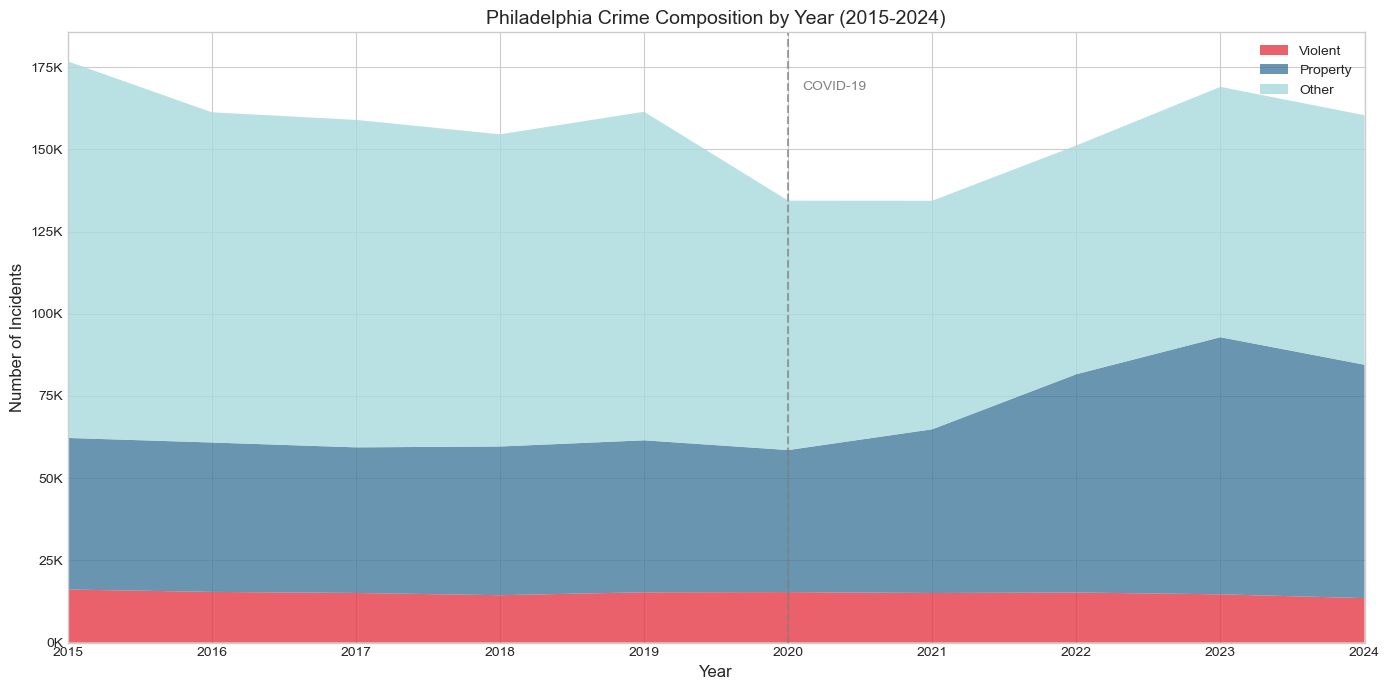


Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/crime_composition_stacked.png


In [8]:
# Primary stacked area chart - absolute counts
fig, ax = plt.subplots(figsize=(14, 7))

years = annual_counts.index
violent = annual_counts['Violent']
property_crime = annual_counts['Property']
other = annual_counts['Other']

# Stacked area with custom colors
ax.stackplot(years,
             violent, property_crime, other,
             labels=['Violent', 'Property', 'Other'],
             colors=['#E63946', '#457B9D', '#A8DADC'],
             alpha=0.8)

# Add COVID marker
ax.axvline(x=2020, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.annotate('COVID-19', (2020.1, annual_counts['Total'].max() * 0.95),
            fontsize=10, color='gray')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Incidents', fontsize=12)
ax.set_title('Philadelphia Crime Composition by Year (2015-2024)', fontsize=14)
ax.legend(loc='upper right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
ax.set_xlim(years.min(), years.max())

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'crime_composition_stacked.png', dpi=300, bbox_inches='tight')
artifacts.append(('crime_composition_stacked.png', 'Stacked area composition chart'))
plt.show()
print(f"\nSaved: {REPORTS_DIR / 'crime_composition_stacked.png'}")

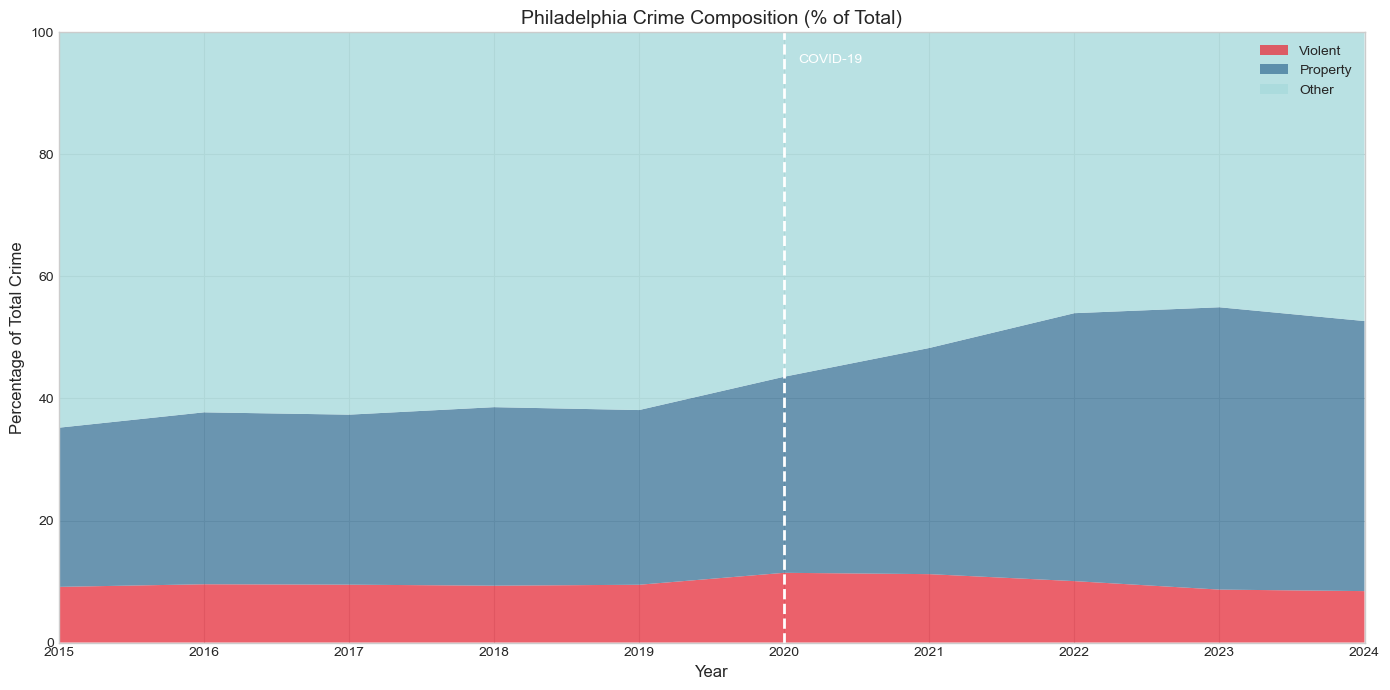

In [9]:
# Percentage stacked area chart
fig, ax = plt.subplots(figsize=(14, 7))

# Normalize to percentages
pct_violent = annual_counts['Violent_Ratio']
pct_property = annual_counts['Property_Ratio']
pct_other = annual_counts['Other_Ratio']

ax.stackplot(years,
             pct_violent, pct_property, pct_other,
             labels=['Violent', 'Property', 'Other'],
             colors=['#E63946', '#457B9D', '#A8DADC'],
             alpha=0.8)

# Add COVID marker
ax.axvline(x=2020, color='white', linestyle='--', linewidth=2)
ax.annotate('COVID-19', (2020.1, 95), fontsize=10, color='white')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Total Crime', fontsize=12)
ax.set_title('Philadelphia Crime Composition (% of Total)', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 100)
ax.set_xlim(years.min(), years.max())

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'crime_composition_pct.png', dpi=300, bbox_inches='tight')
artifacts.append(('crime_composition_pct.png', 'Percentage composition chart'))
plt.show()

## 4. Violent Ratio Trend with Volume Context

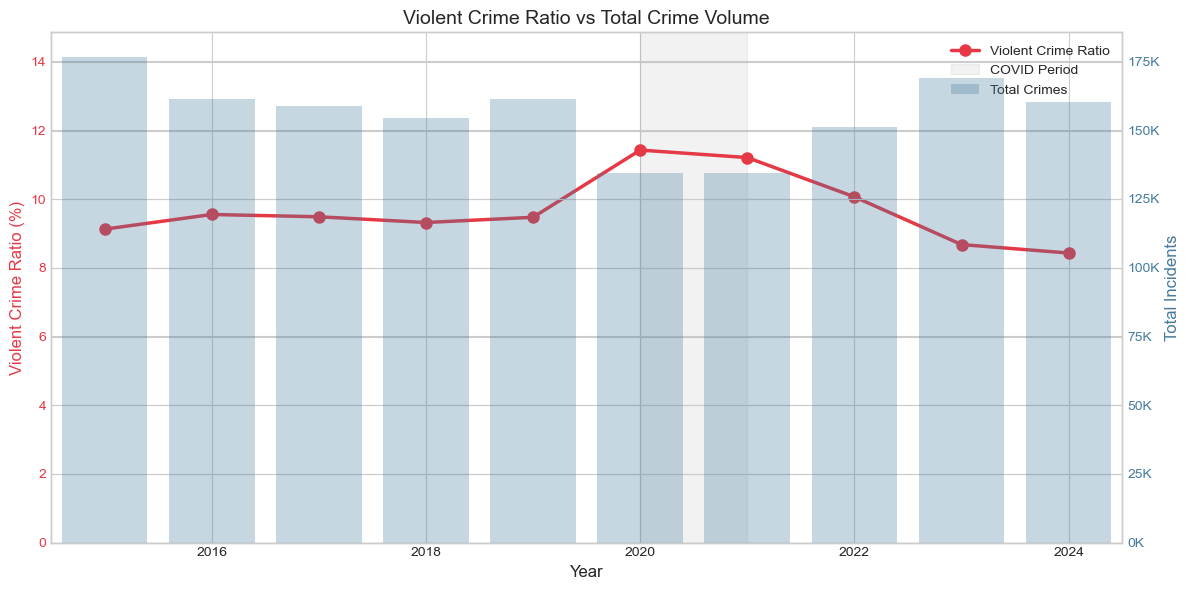

In [10]:
# Dual-axis plot: violent ratio trend with total volume bars
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot violent ratio as line
color = '#E63946'
ax1.plot(years, annual_counts['Violent_Ratio'], 'o-', color=color,
         linewidth=2.5, markersize=8, label='Violent Crime Ratio')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Violent Crime Ratio (%)', fontsize=12, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(annual_counts['Violent_Ratio']) * 1.3)

# Add secondary axis for total crime volume
ax2 = ax1.twinx()
color = '#457B9D'
ax2.bar(years, annual_counts['Total'], alpha=0.3, color=color, label='Total Crimes')
ax2.set_ylabel('Total Incidents', fontsize=12, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Add COVID shading
ax1.axvspan(2020, 2021, alpha=0.1, color='gray', label='COVID Period')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_title('Violent Crime Ratio vs Total Crime Volume', fontsize=14)
ax1.set_xlim(years.min() - 0.5, years.max() + 0.5)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'violent_ratio_trend.png', dpi=300, bbox_inches='tight')
artifacts.append(('violent_ratio_trend.png', 'Violent ratio trend with volume'))
plt.show()

## 5. Violent Crime Sub-Category Analysis

In [11]:
# Get UCR hundred-bands for detailed breakdown
df_analysis['ucr_band'] = pd.to_numeric(df_analysis['ucr_general'], errors='coerce') // 100

# Category labels
ucr_labels = {
    1: 'Homicide',
    2: 'Rape',
    3: 'Robbery',
    4: 'Agg. Assault',
    5: 'Burglary',
    6: 'Theft',
    7: 'Motor Veh. Theft',
    8: 'Arson',
}

df_analysis['ucr_category'] = df_analysis['ucr_band'].map(ucr_labels).fillna('Other')

# Subcategory by year
subcategory_counts = df_analysis.groupby(['year', 'ucr_category']).size().unstack(fill_value=0)

# Violent subcategories only
violent_subcats = ['Homicide', 'Rape', 'Robbery', 'Agg. Assault']
violent_subcats_available = [c for c in violent_subcats if c in subcategory_counts.columns]
violent_detail = subcategory_counts[violent_subcats_available]

print("Violent Crime Breakdown by Year (last 5 years):")
print(violent_detail.tail(5).to_string())

Violent Crime Breakdown by Year (last 5 years):
ucr_category  Homicide  Rape  Robbery  Agg. Assault
year                                               
2020               500   854     4681          9332
2021               562   748     4942          8819
2022               517   589     5798          8324
2023               410   551     5258          8454
2024               269   536     4320          8403


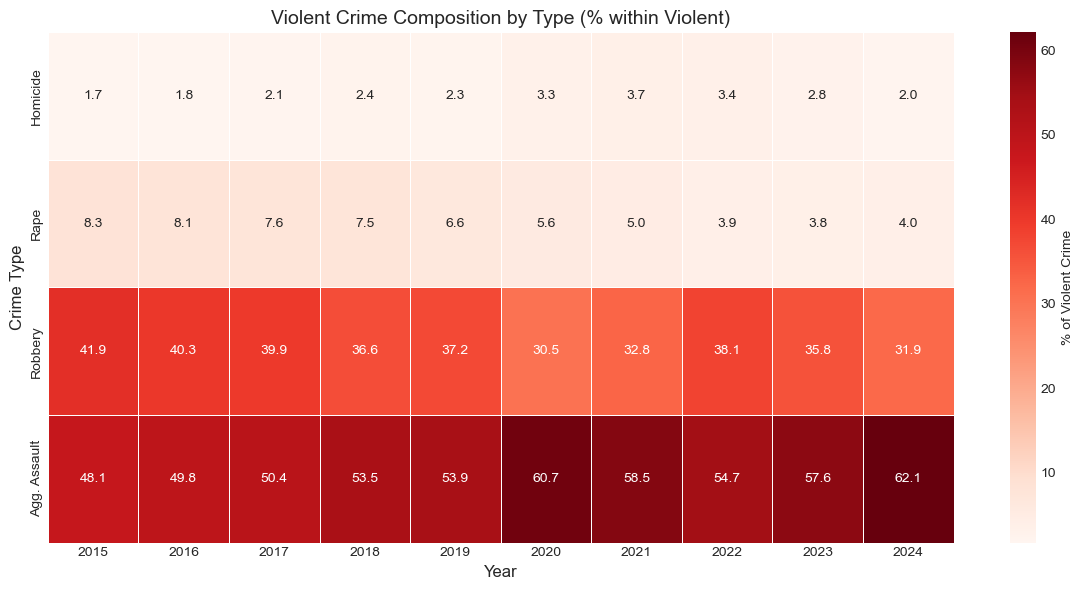

In [12]:
# Violent Crime Composition Heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize within violent crimes (row percentages)
violent_pct = violent_detail.div(violent_detail.sum(axis=1), axis=0) * 100

sns.heatmap(violent_pct.T, annot=True, fmt='.1f', cmap='Reds',
            cbar_kws={'label': '% of Violent Crime'}, ax=ax,
            linewidths=0.5)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Crime Type', fontsize=12)
ax.set_title('Violent Crime Composition by Type (% within Violent)', fontsize=14)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'violent_composition_heatmap.png', dpi=300, bbox_inches='tight')
artifacts.append(('violent_composition_heatmap.png', 'Violent crime subcategory heatmap'))
plt.show()

## 6. Key Findings and Interpretation

In [13]:
# Generate interpretation based on data
if covid_ratio > early_ratio + 1:
    covid_impact = "increased"
    covid_explanation = "likely due to decreased property crime reporting during lockdowns"
else:
    covid_impact = "remained relatively stable"
    covid_explanation = "despite overall crime volume changes"

if recent_ratio < covid_ratio:
    recent_trend = "declining"
    recent_explanation = "returning toward pre-pandemic levels"
else:
    recent_trend = "elevated"
    recent_explanation = "remaining above pre-pandemic baseline"

# Volume change
first_year_total = annual_counts['Total'].iloc[0]
last_year_total = annual_counts['Total'].iloc[-1]
volume_pct_change = (last_year_total - first_year_total) / first_year_total * 100

interpretation = f"""
## Key Findings

### 1. COVID-19 Impact on Crime Composition
The violent crime ratio **{covid_impact}** during 2020-2021 ({covid_ratio:.1f}%), 
{covid_explanation}. This does not necessarily mean more violent crime occurred in 
absolute terms, but rather that violent crime comprised a larger share of reported incidents.

### 2. Recent Trend
The violent crime ratio is currently **{recent_trend}**, {recent_explanation}.
- Current ratio ({analysis_years[-1]}): {annual_counts.loc[analysis_years[-1], 'Violent_Ratio']:.1f}%
- Pre-COVID average (2015-2017): {early_ratio:.1f}%

### 3. Volume Context
Total crime volume **{'decreased' if volume_pct_change < 0 else 'increased'}** by {abs(volume_pct_change):.1f}%
from {first_year_total:,} ({years[0]}) to {last_year_total:,} ({years[-1]}).

### 4. Composition Stability
Despite year-to-year fluctuations, the overall composition remains relatively stable:
- Violent crimes consistently represent **{annual_counts['Violent_Ratio'].min():.0f}-{annual_counts['Violent_Ratio'].max():.0f}%** of total
- Property crimes represent **{annual_counts['Property_Ratio'].min():.0f}-{annual_counts['Property_Ratio'].max():.0f}%** of total

### 5. Violent Crime Internal Composition
Within violent crimes, **Aggravated Assault** remains the dominant category, 
accounting for ~{violent_pct['Agg. Assault'].mean():.0f}% of all violent crimes.
"""

print(interpretation)


## Key Findings

### 1. COVID-19 Impact on Crime Composition
The violent crime ratio **increased** during 2020-2021 (11.3%), 
likely due to decreased property crime reporting during lockdowns. This does not necessarily mean more violent crime occurred in 
absolute terms, but rather that violent crime comprised a larger share of reported incidents.

### 2. Recent Trend
The violent crime ratio is currently **declining**, returning toward pre-pandemic levels.
- Current ratio (2024): 8.4%
- Pre-COVID average (2015-2017): 9.4%

### 3. Volume Context
Total crime volume **decreased** by 9.3%
from 176,768 (2015) to 160,389 (2024).

### 4. Composition Stability
Despite year-to-year fluctuations, the overall composition remains relatively stable:
- Violent crimes consistently represent **8-11%** of total
- Property crimes represent **26-46%** of total

### 5. Violent Crime Internal Composition
Within violent crimes, **Aggravated Assault** remains the dominant category, 
accounting for ~55% of a

## 7. Export Summary Report

In [14]:
# Generate markdown report
report_content = f"""# Crime Composition Analysis Report

**Analysis Period:** {analysis_years[0]}-{analysis_years[-1]}  
**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}  
**Notebook:** `crime_composition.ipynb`

---

## Executive Summary

This analysis examines the year-by-year composition of crime in Philadelphia, 
focusing on the ratio of violent crimes to total crimes and how this has shifted 
across different periods including the COVID-19 pandemic.

## Violent Crime Ratio by Period

| Period | Years | Avg Violent Ratio | Total Violent Crimes |
|--------|-------|-------------------|----------------------|
| Early | 2015-2017 | {early_ratio:.2f}% | {annual_counts.loc[early_available, 'Violent'].sum():,} |
| COVID | 2020-2021 | {covid_ratio:.2f}% | {annual_counts.loc[covid_available, 'Violent'].sum():,} |
| Recent | 2023-2024 | {recent_ratio:.2f}% | {annual_counts.loc[recent_available, 'Violent'].sum():,} |

## Year-by-Year Data

| Year | Total | Violent | Property | Other | Violent % |
|------|-------|---------|----------|-------|-----------|\n"""

for year in years:
    row = annual_counts.loc[year]
    report_content += f"| {year} | {row['Total']:,.0f} | {row['Violent']:,.0f} | {row['Property']:,.0f} | {row['Other']:,.0f} | {row['Violent_Ratio']:.1f}% |\n"

report_content += f"""
{interpretation}

## Methodology

### Crime Classification (UCR Hundred-Bands)
- **Violent crimes:** Homicide (100), Rape (200), Robbery (300), Aggravated Assault (400)
- **Property crimes:** Burglary (500), Theft (600), Motor Vehicle Theft (700)
- **Other crimes:** All remaining UCR categories (800+)

### Data Source
Philadelphia Police Department crime incidents data via OpenDataPhilly.

## Visualizations

- `crime_composition_stacked.png` - Stacked area chart showing absolute crime counts by category
- `crime_composition_pct.png` - Percentage breakdown of crime composition
- `violent_ratio_trend.png` - Violent ratio trend with total volume context
- `violent_composition_heatmap.png` - Sub-category breakdown within violent crimes

---
*Generated by crime_composition.ipynb (POLICY-03)*
"""

# Save report
with open(REPORTS_DIR / 'crime_composition_analysis.md', 'w') as f:
    f.write(report_content)

artifacts.append(('crime_composition_analysis.md', 'Composition analysis report'))
print(f"Report saved to: {REPORTS_DIR / 'crime_composition_analysis.md'}")

Report saved to: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/crime_composition_analysis.md


In [15]:
# Export CSV data
annual_counts.to_csv(REPORTS_DIR / 'crime_composition_annual.csv')
artifacts.append(('crime_composition_annual.csv', 'Annual composition data'))

violent_detail.to_csv(REPORTS_DIR / 'violent_subcategory_annual.csv')
artifacts.append(('violent_subcategory_annual.csv', 'Violent crime subcategory data'))

print("Data exported:")
print(f"  - {REPORTS_DIR / 'crime_composition_annual.csv'}")
print(f"  - {REPORTS_DIR / 'violent_subcategory_annual.csv'}")

Data exported:
  - /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/crime_composition_annual.csv
  - /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/violent_subcategory_annual.csv


## 8. Notebook Completion

In [16]:
runtime = time.time() - RUNTIME_START

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE: Crime Composition Analysis (POLICY-03)")
print("=" * 60)

print("\nKey Findings:")
print(f"  - Violent crime ratio range: {annual_counts['Violent_Ratio'].min():.1f}% to {annual_counts['Violent_Ratio'].max():.1f}%")
print(f"  - Peak year: {max_ratio_year} ({annual_counts.loc[max_ratio_year, 'Violent_Ratio']:.1f}%)")
print(f"  - COVID impact: {covid_ratio - early_ratio:+.2f} percentage points vs pre-COVID")

print("\nArtifacts Generated:")
for name, desc in artifacts:
    print(f"  - {name}: {desc}")

print(f"\nRuntime: {runtime:.1f} seconds")


NOTEBOOK COMPLETE: Crime Composition Analysis (POLICY-03)

Key Findings:
  - Violent crime ratio range: 8.4% to 11.4%
  - Peak year: 2020 (11.4%)
  - COVID impact: +1.93 percentage points vs pre-COVID

Artifacts Generated:
  - crime_composition_stacked.png: Stacked area composition chart
  - crime_composition_pct.png: Percentage composition chart
  - violent_ratio_trend.png: Violent ratio trend with volume
  - violent_composition_heatmap.png: Violent crime subcategory heatmap
  - crime_composition_analysis.md: Composition analysis report
  - crime_composition_annual.csv: Annual composition data
  - violent_subcategory_annual.csv: Violent crime subcategory data

Runtime: 5.3 seconds
